In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from plotting_utils import *
import torch
import numpy as np


In [2]:
import guided_diffusion_v3 as gd

def create_gaussian_diffusion(
    *,
    steps=1000,
    learn_sigma=False,
    sigma_small=False,
    noise_schedule="linear",
    use_kl=False,
    predict_xstart=False,
    rescale_timesteps=False,
    rescale_learned_sigmas=False,
    timestep_respacing="",
):
    betas = gd.get_named_beta_schedule(noise_schedule, steps)
    if use_kl:
        loss_type = gd.LossType.RESCALED_KL
    elif rescale_learned_sigmas:
        loss_type = gd.LossType.RESCALED_MSE
    else:
        loss_type = gd.LossType.MSE
    if not timestep_respacing:
        timestep_respacing = [steps]
    return gd.SpacedDiffusion(
        use_timesteps=gd.space_timesteps(steps, timestep_respacing),
        betas=betas,
        model_mean_type=(
            gd.ModelMeanType.EPSILON if not predict_xstart else gd.ModelMeanType.START_X
        ),
        model_var_type=(
            (
                gd.ModelVarType.FIXED_LARGE
                if not sigma_small
                else gd.ModelVarType.FIXED_SMALL
            )
            if not learn_sigma
            else gd.ModelVarType.LEARNED_RANGE
        ),
        loss_type=loss_type,
        rescale_timesteps=rescale_timesteps,
    )

diffusion = create_gaussian_diffusion()

In [3]:
input_folder = r'C:\Users\u_imagenes\Documents\smerino\testing\input'
output_folder = r'C:\Users\u_imagenes\Documents\smerino\testing\target_enh'
# input_folder = r'C:\Users\sebas\Documents\Data\DiffusionBeamformer\input_overfit'
# output_folder = r'C:\Users\sebas\Documents\Data\DiffusionBeamformer\target_overfit'

data = gd.CustomDataset(input_folder, output_folder, transform=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))


In [4]:
BATCH_SIZE = 1
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
x_sample, y_sample = next(iter(dataloader))
x_sample = x_sample.to(device)
y_sample = y_sample.to(device)

###  A. Not residual, no attention

In [5]:
from model7 import UNETv13

device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
save_dir = r'.\weights\v13A'
training_epochs = 10
model = UNETv13(residual=False, attention_res=[]).to(device)
model.load_state_dict(torch.load(f"{save_dir}\\model_{training_epochs}.pth", map_location=device))
print("Num params: ", sum(p.numel() for p in model.parameters()))



Num params:  32676097


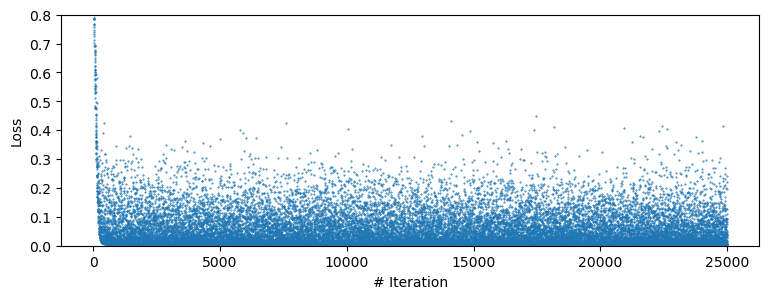

In [6]:
plt.figure(figsize=(9,3))
loss_npy = np.load(f"{save_dir}\\loss_{training_epochs}.npy")
plt.scatter([x for x in range(len(loss_npy))],loss_npy, s=0.2)
plt.xlabel('# Iteration')
plt.ylabel('Loss')
#plt.xlim(000,35000)
plt.ylim(0,0.8)
plt.show()

### Clipped

In [27]:
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
x_sample, y_sample = next(iter(dataloader))
x_sample = x_sample.to(device)
y_sample = y_sample.to(device)

intermediate = []
for step in diffusion.p_sample_loop_progressive(model,y_sample.shape,x_sample, progress=True, clip_denoised=True):
    intermediate.append(step['sample'].cpu().detach())

  0%|          | 0/1000 [00:00<?, ?it/s]

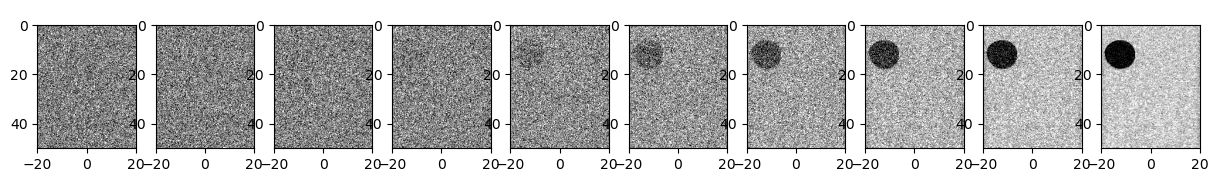

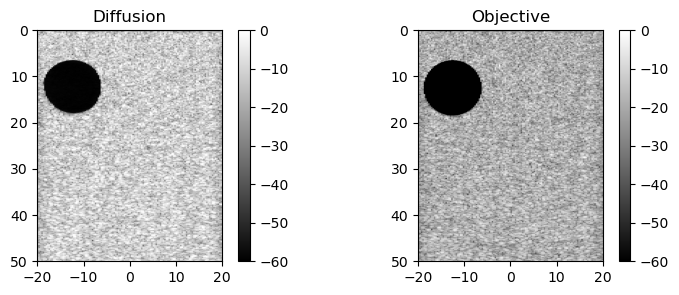

In [28]:
show_reverse_process(intermediate[::100])

plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
show_tensor_image(intermediate[-1])
plt.colorbar()
plt.title('Diffusion')

plt.subplot(1, 2, 2)
show_tensor_image(y_sample.cpu())
plt.colorbar()
plt.title('Objective')
plt.show()


### Not clipped

In [13]:
intermediate = []
for step in diffusion.p_sample_loop_progressive(model,y_sample.shape,x_sample, progress=True, clip_denoised=False):
    intermediate.append(step['sample'].cpu().detach())

  0%|          | 0/1000 [00:00<?, ?it/s]

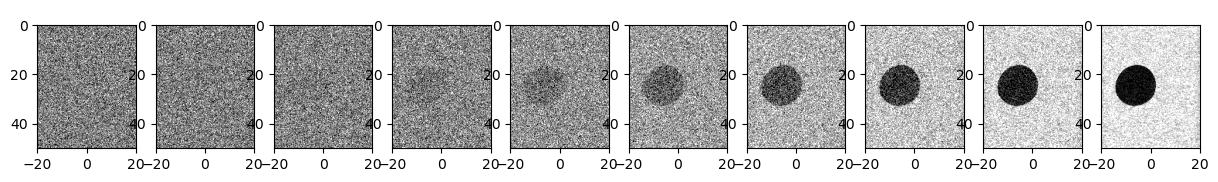

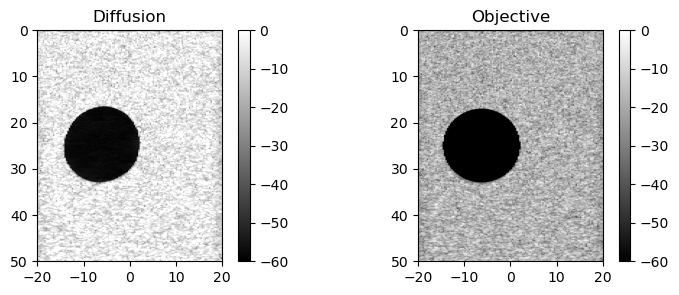

In [14]:
show_reverse_process(intermediate[::100])

plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
show_tensor_image(intermediate[-1])
plt.colorbar()
plt.title('Diffusion')

plt.subplot(1, 2, 2)
show_tensor_image(y_sample.cpu())
plt.colorbar()
plt.title('Objective')
plt.show()


# UNET v11, 1 RRDB block, residual

In [42]:
from model5 import UNETv11

device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
save_dir = r'.\weights\v11_residual'
training_epochs = 10
model11r = UNETv11(rrdb_blocks=1, residual=True).to(device)
model11r.load_state_dict(torch.load(f"{save_dir}\\model_{training_epochs}.pth", map_location=device))
print("Num params: ", sum(p.numel() for p in model.parameters()))

Num params:  34794881


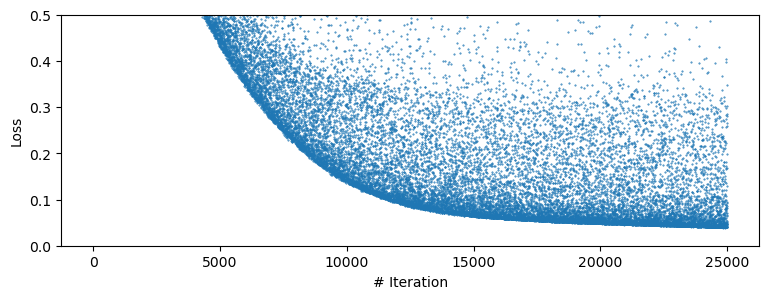

In [43]:
plt.figure(figsize=(9, 3))
loss_npy = np.load(f"{save_dir}\\loss_{training_epochs}.npy")
plt.scatter([x for x in range(len(loss_npy))], loss_npy, s=0.2)
plt.xlabel('# Iteration')
plt.ylabel('Loss')
#plt.xlim(000,35000)
plt.ylim(0, 0.5)
plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

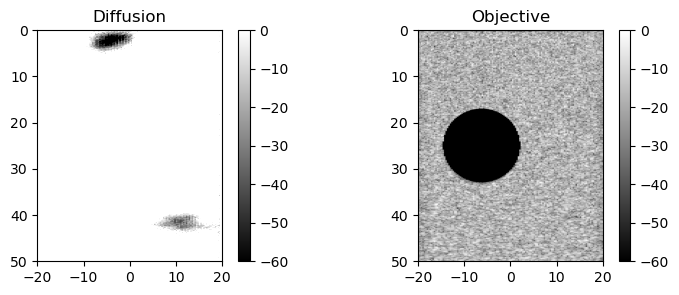

In [44]:
y_gen = diffusion.p_sample_loop(model11r, y_sample.shape, x_sample, progress=True, clip_denoised=False)

plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
show_tensor_image(y_gen.cpu())
plt.colorbar()
plt.title('Diffusion')

plt.subplot(1, 2, 2)
show_tensor_image(y_sample.cpu())
plt.colorbar()
plt.title('Objective')
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

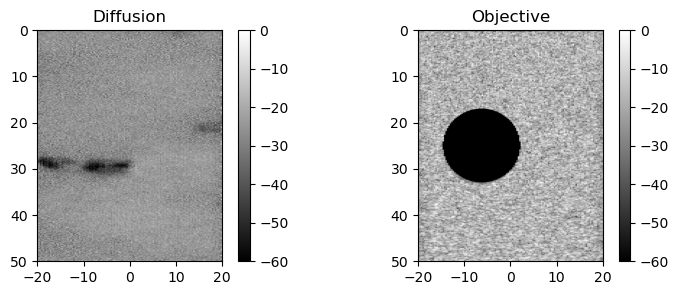

In [45]:

y_gen = diffusion.p_sample_loop(model11r, y_sample.shape, x_sample, progress=True, clip_denoised=True)
plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
show_tensor_image(y_gen.cpu())
plt.colorbar()
plt.title('Diffusion')

plt.subplot(1, 2, 2)
show_tensor_image(y_sample.cpu())
plt.colorbar()
plt.title('Objective')
plt.show()


# UNET v11, 1 RRDB block, not residual

In [11]:
from model5 import UNETv11

device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
save_dir = r'.\weights\v11_RRDB1'
training_epochs = 10
model11 = UNETv11(rrdb_blocks=1, residual=False).to(device)
model11.load_state_dict(torch.load(f"{save_dir}\\model_{training_epochs}.pth", map_location=device))
print("Num params: ", sum(p.numel() for p in model.parameters()))


Num params:  34794881


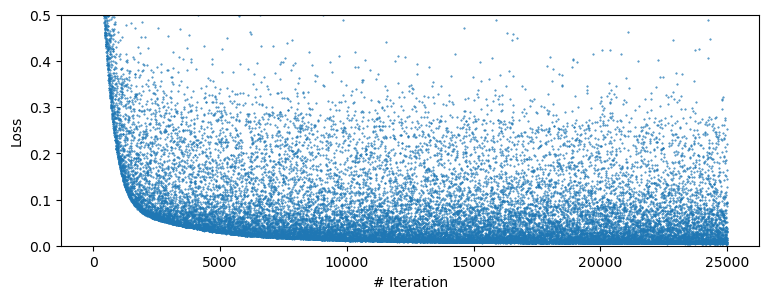

In [12]:
plt.figure(figsize=(9, 3))
loss_npy = np.load(f"{save_dir}\\loss_{training_epochs}.npy")
plt.scatter([x for x in range(len(loss_npy))], loss_npy, s=0.2)
plt.xlabel('# Iteration')
plt.ylabel('Loss')
#plt.xlim(000,35000)
plt.ylim(0, 0.5)
plt.show()

In [13]:
y_gen = diffusion.p_sample_loop(model11,y_sample.shape,x_sample, progress=True, clip_denoised=False)


  0%|          | 0/1000 [00:00<?, ?it/s]

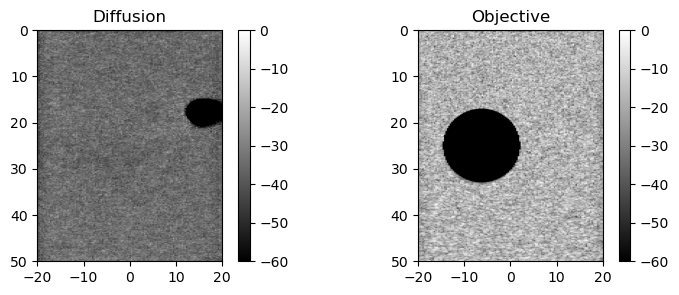

In [14]:
plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
show_tensor_image(y_gen.cpu())
plt.colorbar()
plt.title('Diffusion')

plt.subplot(1, 2, 2)
show_tensor_image(y_sample.cpu())
plt.colorbar()
plt.title('Objective')
plt.show()


In [15]:
y_gen = diffusion.p_sample_loop(model11,y_sample.shape,x_sample, progress=True, clip_denoised=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

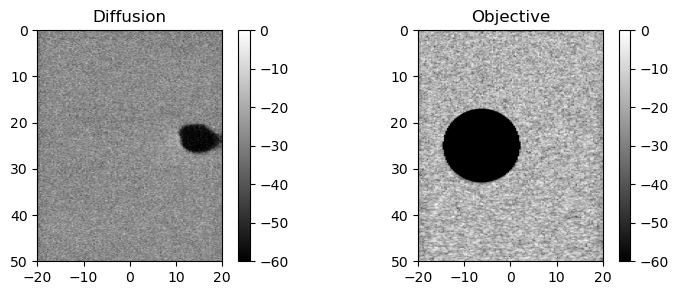

In [16]:
plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
show_tensor_image(y_gen.cpu())
plt.colorbar()
plt.title('Diffusion')

plt.subplot(1, 2, 2)
show_tensor_image(y_sample.cpu())
plt.colorbar()
plt.title('Objective')
plt.show()


# Unet v10.5

In [17]:
from model4 import UNETv10_5

device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
save_dir = r'.\weights\v10_5'
training_epochs = 15
model10 = UNETv10_5().to(device)
model10.load_state_dict(torch.load(f"{save_dir}\\model_{training_epochs}.pth", map_location=device))
print("Num params: ", sum(p.numel() for p in model.parameters()))


Num params:  34794881


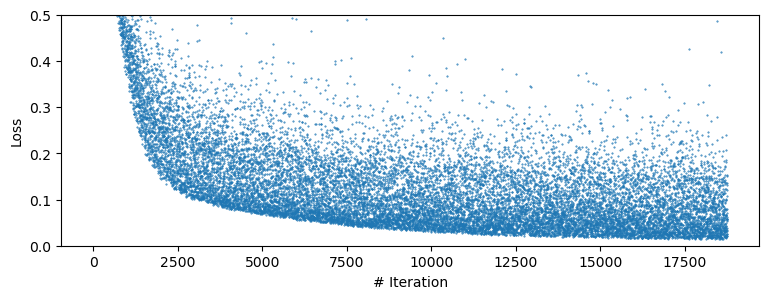

In [18]:
plt.figure(figsize=(9,3))
loss_npy = np.load(f"{save_dir}\\loss_{training_epochs}.npy")
plt.scatter([x for x in range(len(loss_npy))],loss_npy, s=0.2)
plt.xlabel('# Iteration')
plt.ylabel('Loss')
#plt.xlim(000,35000)
plt.ylim(0,0.5)
plt.show()

In [19]:
y_gen = diffusion.p_sample_loop(model10, y_sample.shape, x_sample, progress=True, clip_denoised=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

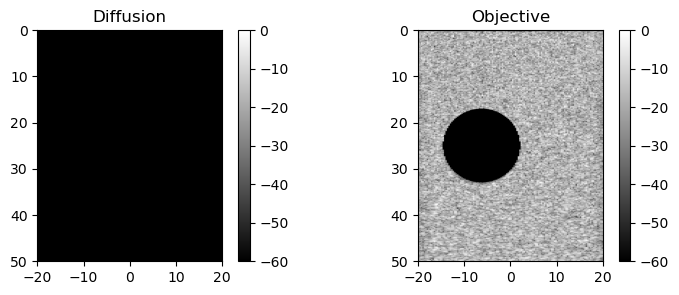

In [20]:

plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
show_tensor_image(y_gen.cpu())
plt.colorbar()
plt.title('Diffusion')

plt.subplot(1, 2, 2)
show_tensor_image(y_sample.cpu())
plt.colorbar()
plt.title('Objective')
plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

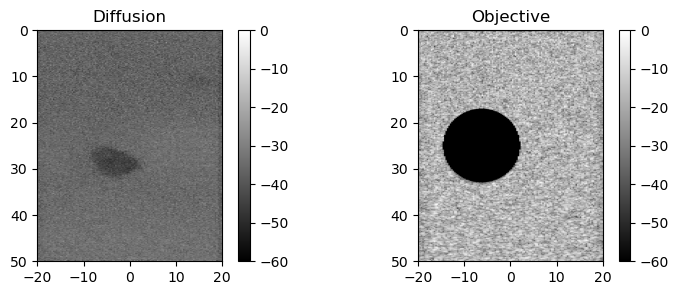

In [21]:
y_gen = diffusion.p_sample_loop(model10, y_sample.shape, x_sample, progress=True, clip_denoised=True)

plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
show_tensor_image(y_gen.cpu())
plt.colorbar()
plt.title('Diffusion')

plt.subplot(1, 2, 2)
show_tensor_image(y_sample.cpu())
plt.colorbar()
plt.title('Objective')
plt.show()
